In [ ]:
# ======================
# Final Scoring (robust to column names)
# ======================
import io
import pandas as pd
from azure.storage.blob import BlobServiceClient

# ---- CONFIG ----
import os
from dotenv import load_dotenv

load_dotenv()  # loads .env file if present (for local dev)

AZURE_CONNECTION_STRING = os.getenv("AZURE_CONN_STR")
CONTAINER_NAME   = "stock-data"
PREDICTIONS_PATH = "predictions"
OUTPUT_PREFIX    = "predictions/final_scored"
TOP_N            = 10

blob_service = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)
container    = blob_service.get_container_client(CONTAINER_NAME)

def blob_exists(path: str) -> bool:
    try:
        container.get_blob_client(path).get_blob_properties()
        return True
    except Exception:
        return False

def load_parquet(path: str) -> pd.DataFrame:
    print(f"📥 Downloading {path} ...")
    data = container.download_blob(path).readall()
    return pd.read_parquet(io.BytesIO(data))

def upload_parquet(df: pd.DataFrame, path: str):
    buf = io.BytesIO()
    df.to_parquet(buf, index=False)
    buf.seek(0)
    container.upload_blob(name=path, data=buf, overwrite=True)
    print(f"☁️ Uploaded: {path}")

def pick_col(cols, preferred, fallbacks):
    """Return first matching column from [preferred]+fallbacks by substring search."""
    if preferred in cols:
        return preferred
    for pat in fallbacks:
        cands = [c for c in cols if pat in c]
        if cands:
            return cands[0]
    raise KeyError(f"Could not find a column among { [preferred]+fallbacks } in {list(cols)[:10]}...")

def process_split(split: str):
    m1_path = f"{PREDICTIONS_PATH}/model1_predictions_{split}.parquet"
    m2_path = f"{PREDICTIONS_PATH}/model2_predictions_{split}.parquet"

    if not (blob_exists(m1_path) and blob_exists(m2_path)):
        print(f"⚠️  Skipping {split}: missing one of {m1_path} or {m2_path}")
        return

    m1 = load_parquet(m1_path)
    m2 = load_parquet(m2_path)
    print(f"✅ {split.upper()} — Model1: {m1.shape}, Model2: {m2.shape}")

    # ---- Find & standardize columns BEFORE merge (avoid suffix chaos)
    prob_col_m1 = pick_col(
        m1.columns,
        preferred="model1_prob",
        fallbacks=["prob", "probability", "score"]
    )
    pred_col_m2 = pick_col(
        m2.columns,
        preferred="model2_pred_return",
        fallbacks=["pred_return", "model2_pred", "prediction", "pred"]
    )

    # Rename to stable names
    m1 = m1.rename(columns={prob_col_m1: "model1_prob_m1"})
    if "model1_pred" in m1.columns:
        m1 = m1.rename(columns={"model1_pred": "model1_pred_m1"})
    m2 = m2.rename(columns={pred_col_m2: "model2_pred_return_m2"})

    # Keep only needed columns from each side to reduce collisions
    m1_keep = ["Date", "Ticker", "model1_prob_m1"]
    if "model1_pred_m1" in m1.columns:
        m1_keep.append("model1_pred_m1")
    m1 = m1[m1_keep]

    # Merge
    merged = m1.merge(m2, on=["Date", "Ticker"], how="inner")

    # Final score
    merged["final_score"] = merged["model1_prob_m1"] * merged["model2_pred_return_m2"]

    # Rank per date and keep Top-N
    merged["rank"] = merged.groupby("Date")["final_score"].rank(ascending=False, method="first")
    topN = merged[merged["rank"] <= TOP_N].reset_index(drop=True)
    print(f"📊 {split.upper()} — kept {len(topN):,} rows (Top {TOP_N} per date)")

    # Save
    out_path = f"{OUTPUT_PREFIX}_{split}.parquet"
    upload_parquet(topN, out_path)

# Run what’s available
for split in ["train", "val", "test"]:
    process_split(split)

print("\n✅ Final scoring finished.")


📥 Downloading predictions/model1_predictions_train.parquet ...
📥 Downloading predictions/model2_predictions_train.parquet ...
✅ TRAIN — Model1: (2748516, 4), Model2: (2504470, 59)
📊 TRAIN — kept 142,636 rows (Top 10 per date)
☁️ Uploaded: predictions/final_scored_train.parquet
📥 Downloading predictions/model1_predictions_val.parquet ...
📥 Downloading predictions/model2_predictions_val.parquet ...
✅ VAL — Model1: (589040, 4), Model2: (481855, 59)
📊 VAL — kept 39,823 rows (Top 10 per date)
☁️ Uploaded: predictions/final_scored_val.parquet
📥 Downloading predictions/model1_predictions_test.parquet ...
📥 Downloading predictions/model2_predictions_test.parquet ...
✅ TEST — Model1: (589192, 4), Model2: (491957, 59)
📊 TEST — kept 23,590 rows (Top 10 per date)
☁️ Uploaded: predictions/final_scored_test.parquet

✅ Final scoring finished.


📥 Downloading predictions/final_scored_test.parquet ...
✅ Loaded 23,590 rows

📅 Latest Date: 2024-08-06 04:00:00+00:00
      Ticker  final_score  future_return
9463   GOOGL     0.264024       0.278638
21058   TTWO     0.261429       0.551424
9089    GOOG     0.250779       0.264857
4971     DIS     0.247777       0.260529
6018      EA     0.184715       0.156302
22472    WBD     0.166762       0.441215
16761    OMC     0.158104      -0.175083
7851       F     0.151883       0.248355
118     ALGN     0.139275      -0.322155
20206    TPL     0.126298       0.120866


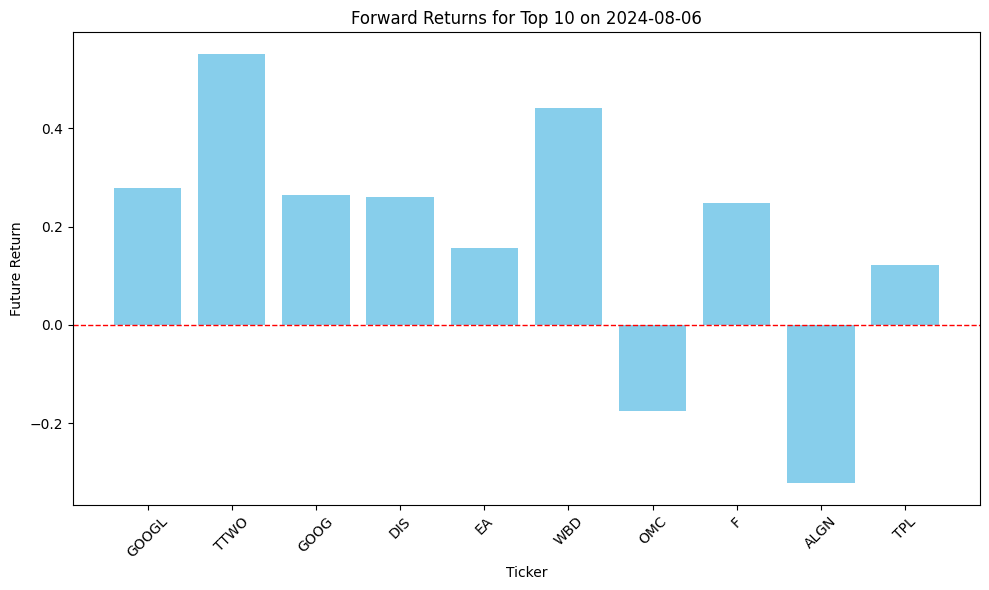

💾 Saved: top10_latest.csv


In [ ]:
# ===========================
# Quick Top 10 Analysis - Test
# ===========================

import io
import pandas as pd
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient

# --- CONFIG ---
import os
from dotenv import load_dotenv

load_dotenv()  # loads .env file if present (for local dev)

AZURE_CONNECTION_STRING = os.getenv("AZURE_CONN_STR")
CONTAINER_NAME = "stock-data"
BLOB_NAME = "predictions/final_scored_test.parquet"

# --- CONNECT ---
blob_service = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)
container = blob_service.get_container_client(CONTAINER_NAME)

# --- LOAD PARQUET FROM BLOB ---
print(f"📥 Downloading {BLOB_NAME} ...")
data_bytes = container.download_blob(BLOB_NAME).readall()
df = pd.read_parquet(io.BytesIO(data_bytes))
print(f"✅ Loaded {len(df):,} rows")

# --- SHOW LATEST TOP 10 ---
latest_date = df["Date"].max()
top10_latest = df[df["Date"] == latest_date].sort_values("final_score", ascending=False).head(10)

print(f"\n📅 Latest Date: {latest_date}")
print(top10_latest[["Ticker", "final_score", "future_return"]])

# --- PLOT FORWARD RETURNS ---
plt.figure(figsize=(10, 6))
plt.bar(top10_latest["Ticker"], top10_latest["future_return"], color="skyblue")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title(f"Forward Returns for Top 10 on {latest_date.date()}")
plt.ylabel("Future Return")
plt.xlabel("Ticker")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- OPTIONAL: Save locally ---
top10_latest.to_csv("top10_latest.csv", index=False)
print("💾 Saved: top10_latest.csv")


In [ ]:
# --- UPLOAD CSV to Blob ---
csv_blob_name = "predictions/top10_latest.csv"
with open("top10_latest.csv", "rb") as f:
    container.upload_blob(name=csv_blob_name, data=f, overwrite=True)
print(f"☁️ Uploaded top 10 CSV to Blob: {csv_blob_name}")

# --- UPLOAD Latest Top 10 Parquet to Blob ---
top10_buf = io.BytesIO()
top10_latest.to_parquet(top10_buf, index=False)
top10_buf.seek(0)
top10_parquet_blob = "predictions/top10_latest.parquet"
container.upload_blob(name=top10_parquet_blob, data=top10_buf, overwrite=True)
print(f"☁️ Uploaded top 10 Parquet to Blob: {top10_parquet_blob}")


☁️ Uploaded top 10 CSV to Blob: predictions/top10_latest.csv
☁️ Uploaded top 10 Parquet to Blob: predictions/top10_latest.parquet
